<a href="https://colab.research.google.com/github/venkatreddyt/HW/blob/master/NER_with_gazetteers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# NLP & ML Final project: Named Entity Recognition with gazetteers
Pavel Nikuiln

## Dataset preparetion

https://www.kaggle.com/abhinavwalia95/entity-annotated-corpus/home#ner.csv

In [1]:
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("ggplot")

In [2]:
data = pd.read_csv("ner_dataset.csv", encoding="latin1")
data = data.drop(['POS'], axis =1)
data = data.fillna(method="ffill")
data.head(20)

FileNotFoundError: ignored

In [ ]:
tags = list(set(data["Tag"].values))
n_tags = len(tags)
n_tags, tags

(17,
 ['I-per',
  'O',
  'B-nat',
  'I-nat',
  'I-gpe',
  'B-art',
  'B-per',
  'B-org',
  'I-art',
  'B-tim',
  'I-tim',
  'I-org',
  'I-eve',
  'B-geo',
  'I-geo',
  'B-gpe',
  'B-eve'])

In [ ]:
PAD_WORD = '--PAD--'

In [ ]:
words = set(list(data['Word'].values))
words.add(PAD_WORD)
n_words = len(words)
print('Number of unique words:', n_words)

Number of unique words: 35179


In [ ]:
class SentenceGetter(object):
    
    def __init__(self, data):
        self.n_sent = 1
        self.data = data
        self.empty = False
        agg_func = lambda s: [(w, t) for w, t in zip(s["Word"].values.tolist(),s["Tag"].values.tolist())]
        self.grouped = self.data.groupby("Sentence #").apply(agg_func)
        self.sentences = [s for s in self.grouped]
    
    def get_next(self):
        try:
            s = self.grouped["Sentence: {}".format(self.n_sent)]
            self.n_sent += 1
            return s
        except:
            return None

In [ ]:
getter = SentenceGetter(data)
sent = getter.get_next()
print(sent)

[('Thousands', 'O'), ('of', 'O'), ('demonstrators', 'O'), ('have', 'O'), ('marched', 'O'), ('through', 'O'), ('London', 'B-geo'), ('to', 'O'), ('protest', 'O'), ('the', 'O'), ('war', 'O'), ('in', 'O'), ('Iraq', 'B-geo'), ('and', 'O'), ('demand', 'O'), ('the', 'O'), ('withdrawal', 'O'), ('of', 'O'), ('British', 'B-gpe'), ('troops', 'O'), ('from', 'O'), ('that', 'O'), ('country', 'O'), ('.', 'O')]


In [ ]:
sentences = getter.sentences
print('Number of sentences in corpus:', len(sentences))

Number of sentences in corpus: 47959


In [ ]:
longest_sen = max(len(sen) for sen in sentences)
print(f'Longest sentence has {longest_sen} words')

Longest sentence has 104 words


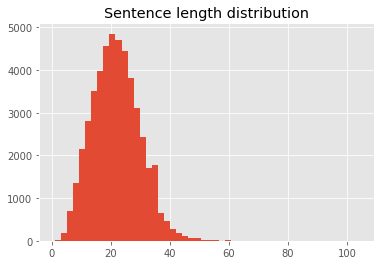

In [ ]:
%matplotlib inline
plt.hist([len(sen) for sen in sentences], bins= 50)
plt.title('Sentence length distribution')
plt.show()

Prepare sentences to be of equal size

In [ ]:
words2index = {w:i for i,w in enumerate(words)}
tags2index = {t:i for i,t in enumerate(tags)}

max_len = 50
X = [[w[0]for w in s] for s in sentences]
padd_X = []
for seq in X:
    new_seq = []
    for i in range(max_len):
        try:
            new_seq.append(seq[i])
        except:
            new_seq.append(PAD_WORD)
    padd_X.append(new_seq)

padd_X[15]

['Israeli',
 'officials',
 'say',
 'Prime',
 'Minister',
 'Ariel',
 'Sharon',
 'will',
 'undergo',
 'a',
 'medical',
 'procedure',
 'Thursday',
 'to',
 'close',
 'a',
 'tiny',
 'hole',
 'in',
 'his',
 'heart',
 'discovered',
 'during',
 'treatment',
 'for',
 'a',
 'minor',
 'stroke',
 'suffered',
 'last',
 'month',
 '.',
 '--PAD--',
 '--PAD--',
 '--PAD--',
 '--PAD--',
 '--PAD--',
 '--PAD--',
 '--PAD--',
 '--PAD--',
 '--PAD--',
 '--PAD--',
 '--PAD--',
 '--PAD--',
 '--PAD--',
 '--PAD--',
 '--PAD--',
 '--PAD--',
 '--PAD--',
 '--PAD--']

Pad labels accordingly with O label for padd word

In [ ]:
from keras.preprocessing.sequence import pad_sequences
y = [[tags2index[w[1]] for w in s] for s in sentences]
y = pad_sequences(maxlen=max_len, sequences=y, padding="post", value=tags2index["O"])
y[15]

array([15,  1,  1,  6,  0,  0,  0,  1,  1,  1,  1,  1,  9,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1],
      dtype=int32)

## Loading gazetteers

https://www.kaggle.com/nltkdata/gazetteers

In [ ]:
os.listdir('./gazetteers')

['mexstates.txt',
 'caprovinces.txt',
 'uscities.txt',
 'nationalities.txt',
 'countries.txt',
 'usstateabbrev.txt',
 'usstates.txt',
 'isocountries.txt']

In [ ]:
gazetteers = {}
for gazetteer in os.listdir('./gazetteers'):
    items = set(open(f'./gazetteers/{gazetteer}', 'r', encoding="latin1").read().strip().split('\n'))
    gazetteers[gazetteer.split('.')[0]] = items

In [ ]:
list(gazetteers['usstateabbrev'])[:8]

['NC', 'AR', 'Okla.', 'WV', 'MD', 'WI', 'LA', 'N.Y.']

# Сreating model

In [ ]:
from sklearn.model_selection import train_test_split
from keras.models import Model, Input, Sequential
from keras.layers.merge import add
from keras.callbacks import ModelCheckpoint 
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional, Lambda, Layer, Concatenate
from keras import backend as K
import tensorflow_hub as hub
import tensorflow as tf
import os

ELMo embedder for word embbeding https://arxiv.org/pdf/1802.05365.pdf

In [ ]:
elmo_model = hub.load('https://tfhub.dev/google/elmo/2').signatures['tokens']
def ElmoEmbedding(x):
    return elmo_model(tokens=tf.squeeze(tf.cast(x, tf.string)), 
                      sequence_len=tf.constant(batch_size*[max_len]))["elmo"]

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Function to extract gazzeteer feature for each word

In [ ]:
def GetGazetteersFeatures(sentences):
    """
    Generate feature vectors based on 
    appearance of each token in gazetteers
    """
    data = []
    for sentence in sentences:
        result = []
        for word in sentence:
            tmp = []
            for gazetteer in gazetteers.values():
                tmp.append(1 if word in gazetteer else 0)

            result.append(tmp)
        data.append(result)
                
    return np.array(data, dtype=np.float32)

Model definition

In [ ]:
def NERModel(number_of_gazetteers, batch_size=32):
    """
    definition of end-to-end NER model
    with additional gazetteer features
    """
    # first input contains sentence splited on tokens
    input_text = Input(shape=(max_len,), dtype=tf.string)
    # second input is gazetteer feature for each token in sentence
    input_gazetteer = Input(shape=(max_len, number_of_gazetteers), dtype=tf.float32)

    # embed input tokens using ELMo embeddings to extract useful features from sentence
    elmo_embedding = Lambda(ElmoEmbedding, output_shape=(max_len, 1024))(input_text)

    # cancatinate ELMo and gazetteer features in one feature vector for each token
    embedding = Concatenate()([elmo_embedding, input_gazetteer])

    # first BiLSTM
    x = Bidirectional(LSTM(units=512, return_sequences=True,
                        recurrent_dropout=0.2, dropout=0.2))(embedding)

    # second BiLSTM
    x_rnn = Bidirectional(LSTM(units=512, return_sequences=True,
                            recurrent_dropout=0.2, dropout=0.2))(x)
    # add them together
    x = add([x, x_rnn])

    # assign lable
    out = TimeDistributed(Dense(n_tags, activation="softmax"))(x)

    model = Model([input_text, input_gazetteer], out)

    return model

In [ ]:
batch_size = 32
number_of_gazetteers=len(gazetteers.values())

model = NERModel(number_of_gazetteers=number_of_gazetteers, batch_size=batch_size)
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 50)           0                                            
__________________________________________________________________________________________________
lambda_3 (Lambda)               (None, 50, 1024)     0           input_5[0][0]                    
__________________________________________________________________________________________________
input_6 (InputLayer)            (None, 50, 8)        0                                            
__________________________________________________________________________________________________
concatenate_3 (Concatenate)     (None, 50, 1032)     0           lambda_3[0][0]                   
                                                                 input_6[0][0]              

In [ ]:
l = len(padd_X) // batch_size // 25 * 25 * batch_size 
X_train, X_test, y_train, y_test = train_test_split(padd_X[:l], y[:l], test_size=0.2)
y_train = y_train.reshape(y_train.shape[0], y_train.shape[1], 1)

print(*map(len, [X_train, X_test, y_train, y_test]))

37760 9440 37760 9440


## Train and Test section

In [ ]:
history = model.fit([np.array(X_train), GetGazetteersFeatures(X_train)], y_train, validation_split = 0.2,
                    batch_size=batch_size, epochs=3, verbose=1)

In [ ]:
!pip install seqeval

  Created wheel for seqeval: filename=seqeval-0.0.12-cp36-none-any.whl size=7424 sha256=f930e00be25aeb85839c2cdc0df2493162757f23f43f74eaecf6ed7f8e9c1c9a
  Stored in directory: /root/.cache/pip/wheels/4f/32/0a/df3b340a82583566975377d65e724895b3fad101a3fb729f68
Successfully built seqeval


In [ ]:
from seqeval.metrics import precision_score, recall_score, f1_score, classification_report

test_pred = model.predict([np.array(X_test), GetGazetteersFeatures(X_test)], verbose=1)

9440/9440 [==============================] - 175s 19ms/step


## Result and Score section

In [ ]:
idx2tag = {i: w for w, i in tags2index.items()}

def pred2label(pred):
    out = []
    for pred_i in pred:
        out_i = []
        for p in pred_i:
            p_i = np.argmax(p)
            out_i.append(idx2tag[p_i].replace(PAD_WORD, "O"))
        out.append(out_i)
    return out

def test2label(pred):
    out = []
    for pred_i in pred:
        out_i = []
        for p in pred_i:
            out_i.append(idx2tag[p].replace(PAD_WORD, "O"))
        out.append(out_i)
    return out
    
pred_labels = pred2label(test_pred)
test_labels = test2label(y_test)
print(classification_report(test_labels, pred_labels))

           precision    recall  f1-score   support

      gpe       0.96      0.92      0.94      3105
      geo       0.81      0.91      0.86      7305
      org       0.73      0.61      0.66      3962
      per       0.74      0.80      0.77      3362
      tim       0.86      0.85      0.86      4056
      nat       0.19      0.66      0.30        29
      eve       0.15      0.32      0.20        53
      art       0.46      0.15      0.22        74

micro avg       0.81      0.83      0.82     21946
macro avg       0.81      0.83      0.82     21946



In [ ]:
i = 378
p = model.predict([np.array(X_test[i:i+batch_size]), GetGazetteersFeatures(X_test[i:i+batch_size])])[0]
p = np.argmax(p, axis=-1)
print("{:15} {:5}: ({})".format("Word", "Pred", "True"))
print("="*30)
for w, true, pred in zip(X_test[i], y_test[i], p):
    if w != PAD_WORD:
        print("{:15}:{:5} ({})".format(w, tags[pred], tags[true]))

Word            Pred : (True)
This           :O     (O)
year           :O     (O)
,              :O     (O)
an             :O     (O)
unprecedented  :O     (O)
26             :O     (O)
tropical       :O     (O)
storms         :O     (O)
have           :O     (O)
raged          :O     (O)
in             :O     (O)
the            :O     (O)
Atlantic       :B-geo (B-geo)
since          :O     (O)
the            :O     (O)
season         :O     (B-tim)
began          :O     (O)
on             :O     (O)
June           :B-tim (B-tim)
first          :I-tim (I-tim)
.              :O     (O)


## References

https://arxiv.org/pdf/1802.05365.pdf

https://arxiv.org/pdf/1603.01354.pdf

https://arxiv.org/pdf/1901.08746.pdf

https://www.aclweb.org/anthology/W19-5807.pdf

https://programminghistorian.org/en/lessons/extracting-keywords

https://towardsdatascience.com/named-entity-recognition-ner-meeting-industrys-requirement-by-applying-state-of-the-art-deep-698d2b3b4ede

https://www.kaggle.com/nltkdata/conll-corpora

https://mc.ai/how-to-build-deep-neural-network-for-custom-ner-with-keras/

https://medium.com/analytics-vidhya/elmo-embedding-the-entire-intent-of-a-query-530b268c4cd

https://www.depends-on-the-definition.com/named-entity-recognition-conditional-random-fields-python/

https://towardsdatascience.com/elmo-embeddings-in-keras-with-tensorflow-hub-7eb6f0145440

https://confusedcoders.com/data-science/deep-learning/how-to-build-deep-neural-network-for-custom-ner-with-keras